# 基于LSTM模型的预测算法

In [1]:
import tensorflow as tf
import numpy as np
import warnings
import DataPreProcess
import matplotlib.pyplot as plt
import os

import Visualization
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 禁用GPU,实验结果可复现。
warnings.filterwarnings("ignore")

# 数据导入
# 定义数据的位置
# 2013-11、2013-12是米兰市100*100网络中心的20*20的网络数据
# 2013-11-fusion、2013-12-fusion是将100*100网络聚合成20*20网络之后的数据

total_data_path = './Data/total.vocab'
data_11 = './data/2013-11-fusion.vocab'
data_12 = './data/2013-12-fusion.vocab'
max_min_path = './Data/loc_max_mix.vocab'

In [2]:
# 处理缺失值
data_without_missing_value = DataPreProcess.ProcessMissingValue(data_11, data_12, city_amount=400, judge_num=7)

# 处理异常值
data_without_abnormal_value = DataPreProcess.ProcessAbnormalValue(data_without_missing_value, city_amount=400, judge_week_num=8, judge_day_num=30)


total_data = data_without_abnormal_value.reshape(60, 400, 24)

There are 122 missing datas
There are 3364 abnormal num


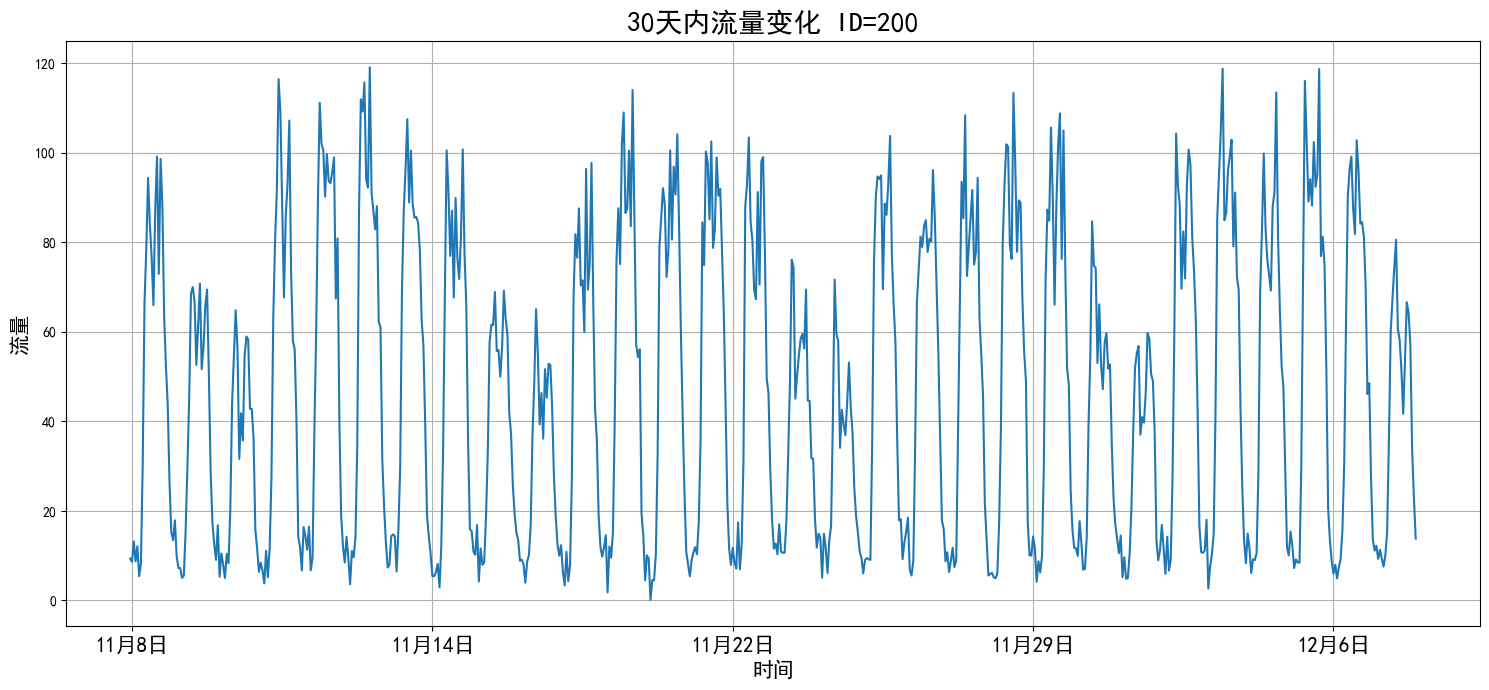

In [3]:
#选取ID=200的栅格区域
id = 200
#选取第7天-第43天的数据
series =total_data[7:44,id,:].reshape(888)
time = np.arange(len(series))

#可视化30天内的流量数据
plt.figure(figsize=(15, 7))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['font.serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(time[0:720], series[0:720], '-')
plt.xlabel("时间",fontsize=15)
plt.ylabel("流量",fontsize=15)
plt.title("30天内流量变化 ID=%d" % (id),fontsize=20)
date = ['11月8日', '11月14日', '11月22日', '11月29日', '12月6日']
dt = list(range(len(series[0:720])))
plt.xticks(range(1, len(dt), 7*24), date, rotation=0,fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('./results/5-4-9.svg', format='svg')
plt.show()

In [5]:
# 划分训练集和测试集
t_time = 720
split_time = 600  # 可以尝试600 300
time_train = time[t_time - split_time:t_time]
x_train = series[t_time - split_time:t_time]
time_test = time[t_time:]
X_test = series[t_time:]

window_size = 100  # 可以尝试4 12 24 100
batch_size = 32  # 2^n
if split_time % 3 == 0:
    shuffle_buffer_size = np.float64(split_time / 3)
else:
    shuffle_buffer_size = np.float64(split_time / 2)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # 函数功能：制作基于滑动窗口的数据集，将数据集按照窗口大小和步长进行切分，并
    #          将所有窗口数据展平成一个大的数据集，对数据集随机采样，最后将每个
    #          样本划分为训练数据和目标数据。
    #    输入：series—输入训练数据
    #          window_size—滑动窗口的大小，即每个样本包含多少个连续时间步的数据
    #          batch_size—数据批量大小，即每次训练模型时输入的样本数量
    #          shuffle_buffer—做随机采样使用的缓冲大小，用来打乱数据集中数据顺序
    #    输出：ds.batch(batch_size).prefetch(1) —大小为batch_size的数据集

    series = tf.expand_dims(series, axis=-1)  # 输入训练数据进行一维展平
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)  # 将数据集按照窗口大小和步长进行切分
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)  # 对数据集进行随机采样，以防止训练过程中的过拟合
    ds = ds.map(lambda w: (w[:-1], w[1:]))  # 将每个样本划分为训练数据和目标数据。
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    # 输入训练完成后的模型，和历史序列以及滑动窗口大小。并返回预测结果
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# 划分训练集和测试集
t_time = 720
split_time = 600  # 可以尝试600 300
time_train = time[t_time - split_time:t_time]
x_train = series[t_time - split_time:t_time]
time_test = time[t_time:]
X_test = series[t_time:]

window_size = 100  # 可以尝试4 12 24 100
batch_size = 32  # 2^n
if split_time % 3 == 0:
    shuffle_buffer_size = np.float64(split_time / 3)
else:
    shuffle_buffer_size = np.float64(split_time / 2)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # 函数功能：制作基于滑动窗口的数据集，将数据集按照窗口大小和步长进行切分，并
    #          将所有窗口数据展平成一个大的数据集，对数据集随机采样，最后将每个
    #          样本划分为训练数据和目标数据。
    #    输入：series—输入训练数据
    #          window_size—滑动窗口的大小，即每个样本包含多少个连续时间步的数据
    #          batch_size—数据批量大小，即每次训练模型时输入的样本数量
    #          shuffle_buffer—做随机采样使用的缓冲大小，用来打乱数据集中数据顺序
    #    输出：ds.batch(batch_size).prefetch(1) —大小为batch_size的数据集

    series = tf.expand_dims(series, axis=-1)  # 输入训练数据进行一维展平
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)  # 将数据集按照窗口大小和步长进行切分
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)  # 对数据集进行随机采样，以防止训练过程中的过拟合
    ds = ds.map(lambda w: (w[:-1], w[1:]))  # 将每个样本划分为训练数据和目标数据。
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    # 输入训练完成后的模型，和历史序列以及滑动窗口大小。并返回预测结果
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


tf.random.set_seed(47)
np.random.seed(47)

# 得到经过时间窗切片的滑动窗口训练数据的测试训练数据
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(X_test, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

#优化器 Adam学习率1e-3 （可调节）
optimizer = tf.keras.optimizers.Adam(lr=0.001)
LOSS = tf.keras.losses.Huber()

In [6]:
#LSTM模型
LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
LSTM.compile(loss=LOSS,
              optimizer=optimizer,
              metrics=["mae"])
# 模型训练
LSTM_history = LSTM.fit(train_set, epochs=100)
LSTM.summary()
# 模型预测
LSTM_forecast = model_forecast(LSTM, series[..., np.newaxis], window_size)
LSTM_forecast = LSTM_forecast[t_time - window_size:-1, -1, 0]

tf.keras.backend.clear_session()

Epoch 1/100
16/16 [==============================] - 5s 65ms/step - loss: 13.4668 - mae: 13.9586
Epoch 2/100
16/16 [==============================] - 1s 51ms/step - loss: 9.2029 - mae: 9.6913
Epoch 3/100
16/16 [==============================] - 1s 47ms/step - loss: 8.2549 - mae: 8.7413
Epoch 4/100
16/16 [==============================] - 1s 49ms/step - loss: 7.9184 - mae: 8.4019
Epoch 5/100
16/16 [==============================] - 1s 47ms/step - loss: 7.7039 - mae: 8.1860
Epoch 6/100
16/16 [==============================] - 1s 49ms/step - loss: 7.5799 - mae: 8.0609
Epoch 7/100
16/16 [==============================] - 1s 49ms/step - loss: 7.4539 - mae: 7.9341
Epoch 8/100
16/16 [==============================] - 1s 49ms/step - loss: 7.3681 - mae: 7.8467
Epoch 9/100
16/16 [==============================] - 1s 50ms/step - loss: 7.3397 - mae: 7.8190
Epoch 10/100
16/16 [==============================] - 1s 50ms/step - loss: 7.3386 - mae: 7.8186
Epoch 11/100
16/16 [===========================

In [7]:
#LSTM+Conv1D模型
LSTM_Conv1D = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=36,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
LSTM_Conv1D.compile(loss=LOSS,
              optimizer=optimizer,
              metrics=["mae"])
# 模型训练
LSTM_Conv1D_history = LSTM_Conv1D.fit(train_set, epochs=100)
LSTM_Conv1D.summary()
# 模型预测
LSTM_Conv1D_forecast = model_forecast(LSTM_Conv1D, series[..., np.newaxis], window_size)
LSTM_Conv1D_forecast = LSTM_Conv1D_forecast[t_time - window_size:-1, -1, 0]

Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 21.8724 - mae: 22.3652
Epoch 2/100
16/16 [==============================] - 1s 60ms/step - loss: 9.7383 - mae: 10.2215
Epoch 3/100
16/16 [==============================] - 1s 62ms/step - loss: 8.8039 - mae: 9.2867
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 8.4722 - mae: 8.9531
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 7.0497 - mae: 7.5288
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 6.6069 - mae: 7.0855
Epoch 7/100
16/16 [==============================] - 1s 62ms/step - loss: 6.2269 - mae: 6.7054
Epoch 8/100
16/16 [==============================] - 1s 59ms/step - loss: 5.9167 - mae: 6.3921
Epoch 9/100
16/16 [==============================] - 1s 59ms/step - loss: 5.8047 - mae: 6.2780
Epoch 10/100
16/16 [==============================] - 1s 58ms/step - loss: 5.5919 - mae: 6.0661
Epoch 11/100
16/16 [==========================

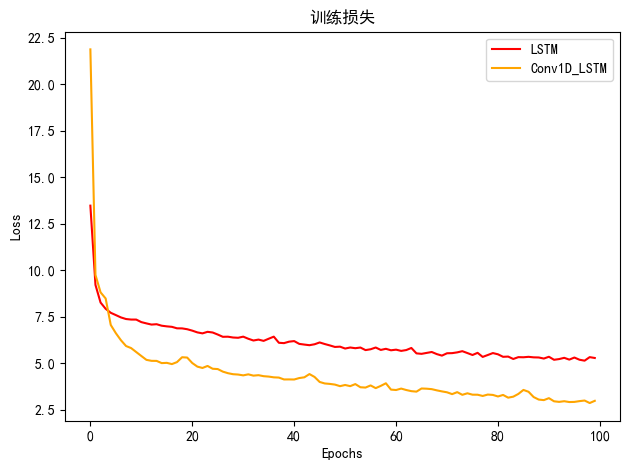

In [8]:
# Loss可视化
plt.figure()
plt.plot(range(len(LSTM_history.history['loss'])), LSTM_history.history['loss'], 'r', label='LSTM')
plt.plot(range(len(LSTM_Conv1D_history.history['loss'])), LSTM_Conv1D_history.history['loss'], 'orange', label='Conv1D_LSTM')
plt.title('训练损失')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig('./results/5-4-10.svg', format='svg')
plt.show()

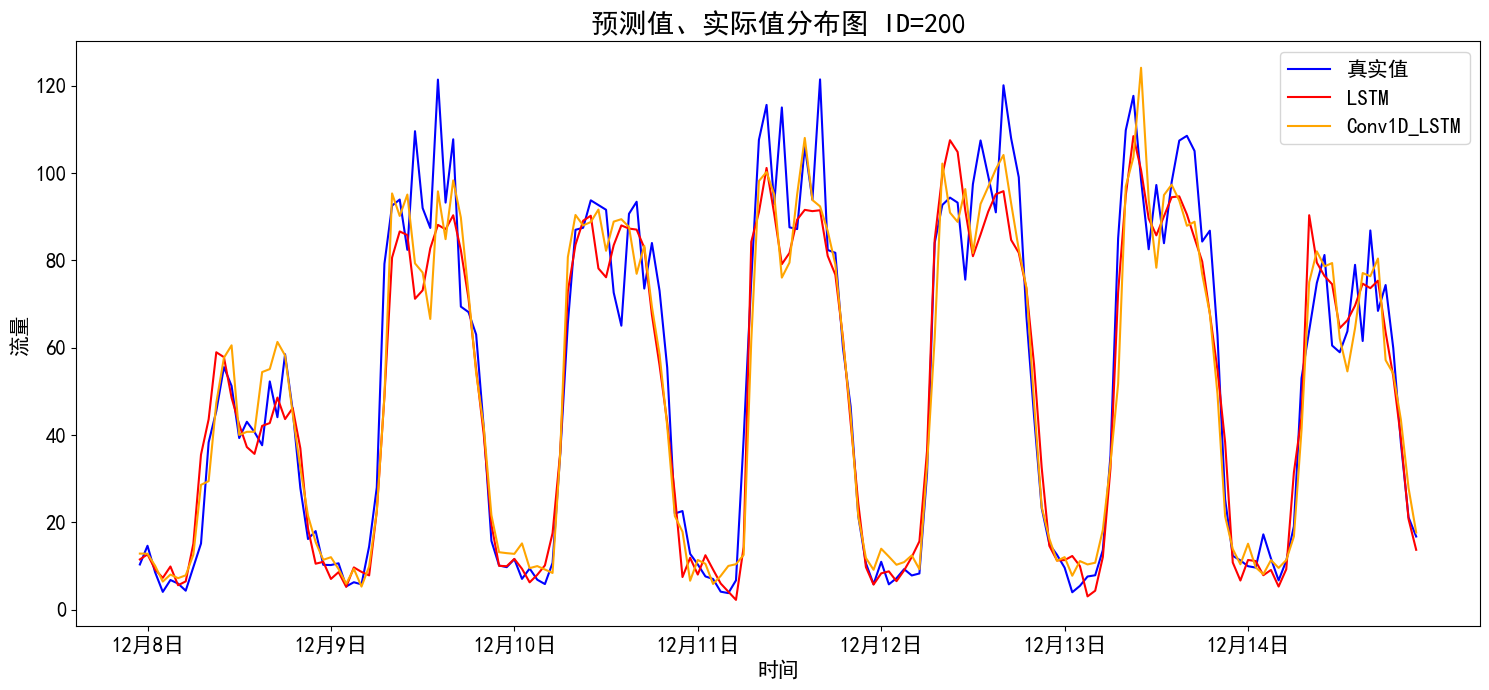

In [9]:
# 预测结果可视化
plt.figure(figsize=(15,7))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['font.serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(np.arange(len(time_test)), series[time_test], color='b', label='真实值',)
plt.plot(np.arange(len(time_test)), LSTM_forecast, color='r', label='LSTM',)
plt.plot(np.arange(len(time_test)), LSTM_Conv1D_forecast, color='orange', label='Conv1D_LSTM',)
dt = list(range(len(time_test)))
date = ['12月8日', '12月9日', '12月10日', '12月11日', '12月12日', '12月13日', '12月14日']
plt.xticks(range(1, len(dt), 24), date, rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.title('预测值、实际值分布图 ID=%d'%(id), fontsize=20)
plt.xlabel('时间', fontsize=15)
plt.ylabel('流量', fontsize=15)
plt.tight_layout()
plt.savefig('./results/5-4-11.svg', format='svg')
plt.show()

In [10]:
#性能结果
RMSE =Visualization.CalculateRMSE(LSTM_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))
MAE = Visualization.CalculateMAE(LSTM_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))
R2 = Visualization.CalculateR2score(LSTM_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))

RMSE_1 =Visualization.CalculateRMSE(LSTM_Conv1D_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))
MAE_1 = Visualization.CalculateMAE(LSTM_Conv1D_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))
R2_1 = Visualization.CalculateR2score(LSTM_Conv1D_forecast.reshape((-1, 1)), X_test.reshape((-1, 1)))

print('LSTM -> RMSE: %f.  MAE: %f.  R2_score: %f.' % (RMSE, MAE, R2))
print('LSTM+Conv1D -> RMSE: %f.  MAE: %f.  R2_score: %f.' % (RMSE_1, MAE_1, R2_1))

LSTM -> RMSE: 10.826864.  MAE: 7.742703.  R2_score: 0.899423.
LSTM+Conv1D -> RMSE: 10.952102.  MAE: 7.724796.  R2_score: 0.899703.
